In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

### Load model

In [9]:
ie = Core()

model = ie.read_model(model="./intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml")
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = next(iter(compiled_model.inputs))

### Load Image

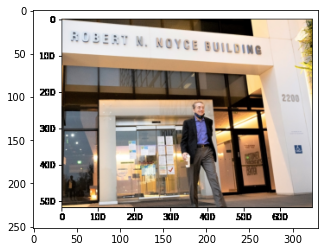

In [10]:
# 画像がないからエラーが出るのは当然。後で写真を入れておくこと
image = cv2.imread('data/test.jpg')

# N, C, H, W = batch size, number of channels, height, width
N, C, H, W = input_layer_ir.shape

# Resize image to meet network expected input sizes
resize_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resize_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Inference

In [11]:
# Create inference request
request = compiled_model.create_infer_request()
request.infer({input_layer_ir.any_name: input_image})

boxes = request.get_tensor("boxes").data

# Remove zero only boxes
boxes = boxes[~np.all(boxes == 0, axis=1)]

### Visualize Results

In [12]:
# For each detection, the description has the format: [x_min, y_min, x_max, y_max, conf]
# Image passed here is in BGR format with changed width and height. To didsplay it in colors expected by matplotlib we use cvtColor function

def convert_result_to_image(bgr_image, resize_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resize_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert base image from bgr to rgb format
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image, 
            # We position upper box bar little lower to make it visible on image
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw box based on position, parameters in rectangle function are: image, start_point, end_point, color, thickness
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors['green'], 3)

            # Add text to image based on position and confidence
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors['red'],
                    1,
                    cv2.LINE_AA,
                )
    return rgb_image

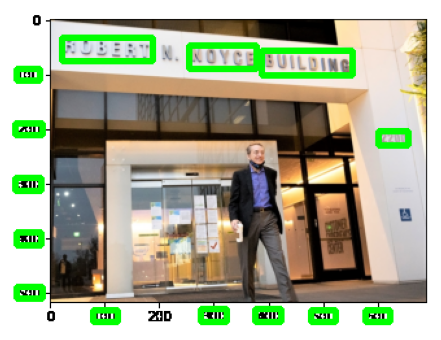

In [13]:
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.imshow(convert_result_to_image(image, resize_image, boxes, conf_labels=False))